In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import fftpack
from scipy import signal

Firstly, we download the datafile center_sternum.txt into a pandas dataframe . We consider every measurment taken every 0.005 s (frequency is 200 Hz). We decide to take care of the linear acceleration (in g), the angular velocity (in degree per second) and the magnetic field (in mgauss) in all three the directions. The quaternions are initially not considered, so we drop them. 

In [19]:
file_name="center_sternum.txt"
data=pd.read_csv(file_name, "\t")

C:\Users\sacco\Downloads\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3369: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [20]:
freqs = data["Log Freq"].unique()
freq = np.bincount(freqs).argmax()
dt = 1.0/freq   #We controlled that every measure is 200 Hz and then calculate dt=1/200

initial_time=data.loc[0, "Timestamp"]
data["Abs Time"] = np.zeros(len(data))
for value, table in data.groupby("Timestamp"):    #We create a column of times
    data.loc[data["Timestamp"] == value, "Abs Time"] = value - initial_time + np.arange(0, len(table),1)/len(table)

labels=["GyroX", "GyroY", "GyroZ", "AccX", "AccY", "AccZ", "MagnX", "MagnY", "MagnZ", "qi", "qj", "qk", "qw"]
Nvar = len(labels)
data=data.drop(["Log Mode"], axis=1)  #We drop this columns of data
data

,Log Freq,Timestamp,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ,qw,qi,qj,qk,Abs Time
0,200,1576222772,947.086,435.662,70.638,-6.824428,-14.244280,1.404580,-454,-490,-178,0.792622,0.254952,-0.553850,-0.000031,0.000000
1,200,1576222772,969.168,387.777,88.877,6.183206,-12.290080,-7.969466,-454,-490,-177,0.736461,0.275124,-0.617969,0.006806,0.004464
2,200,1576222772,989.603,380.335,78.751,11.709920,-4.961832,-7.450382,-454,-490,-177,0.729465,0.275246,-0.626118,0.009827,0.008929
3,200,1576222772,954.894,418.033,88.328,17.877860,2.519084,-5.984733,-454,-492,-176,0.723413,0.277200,-0.632221,0.011383,0.013393
4,200,1576222772,972.096,427.732,99.857,25.221370,5.404580,4.015267,-454,-492,-176,0.721948,0.280007,-0.632679,0.010193,0.017857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16501,200,1576222847,958.493,291.092,-54.290,1.664122,2.305344,-0.671756,-494,-449,-126,0.650810,0.379162,-0.636402,0.166356,75.972527
16502,200,1576222847,954.650,288.042,-49.654,1.480916,2.488550,-0.702290,-494,-450,-125,0.650239,0.379803,-0.636708,0.165960,75.978022
16503,200,1576222847,967.338,290.482,-63.867,1.114504,3.374046,-0.900763,-494,-450,-125,0.649365,0.380627,-0.637227,0.165502,75.983516
16504,200,1576222847,965.630,300.852,-56.242,0.702290,3.664122,-1.587786,-495,-448,-124,0.648973,0.381329,-0.637348,0.164953,75.989011


Now, we plot the accelerations and the angular velocity with respect to the time. In this way we have a first idea about the data, in particular we understand which windows of time is ideal to studying the dataset. We look for times where there's not anomalous variation of acceleration or velocity (maybe some movements of the body independent from the hearth rate, and respiration rate) that we do not want to consider. 

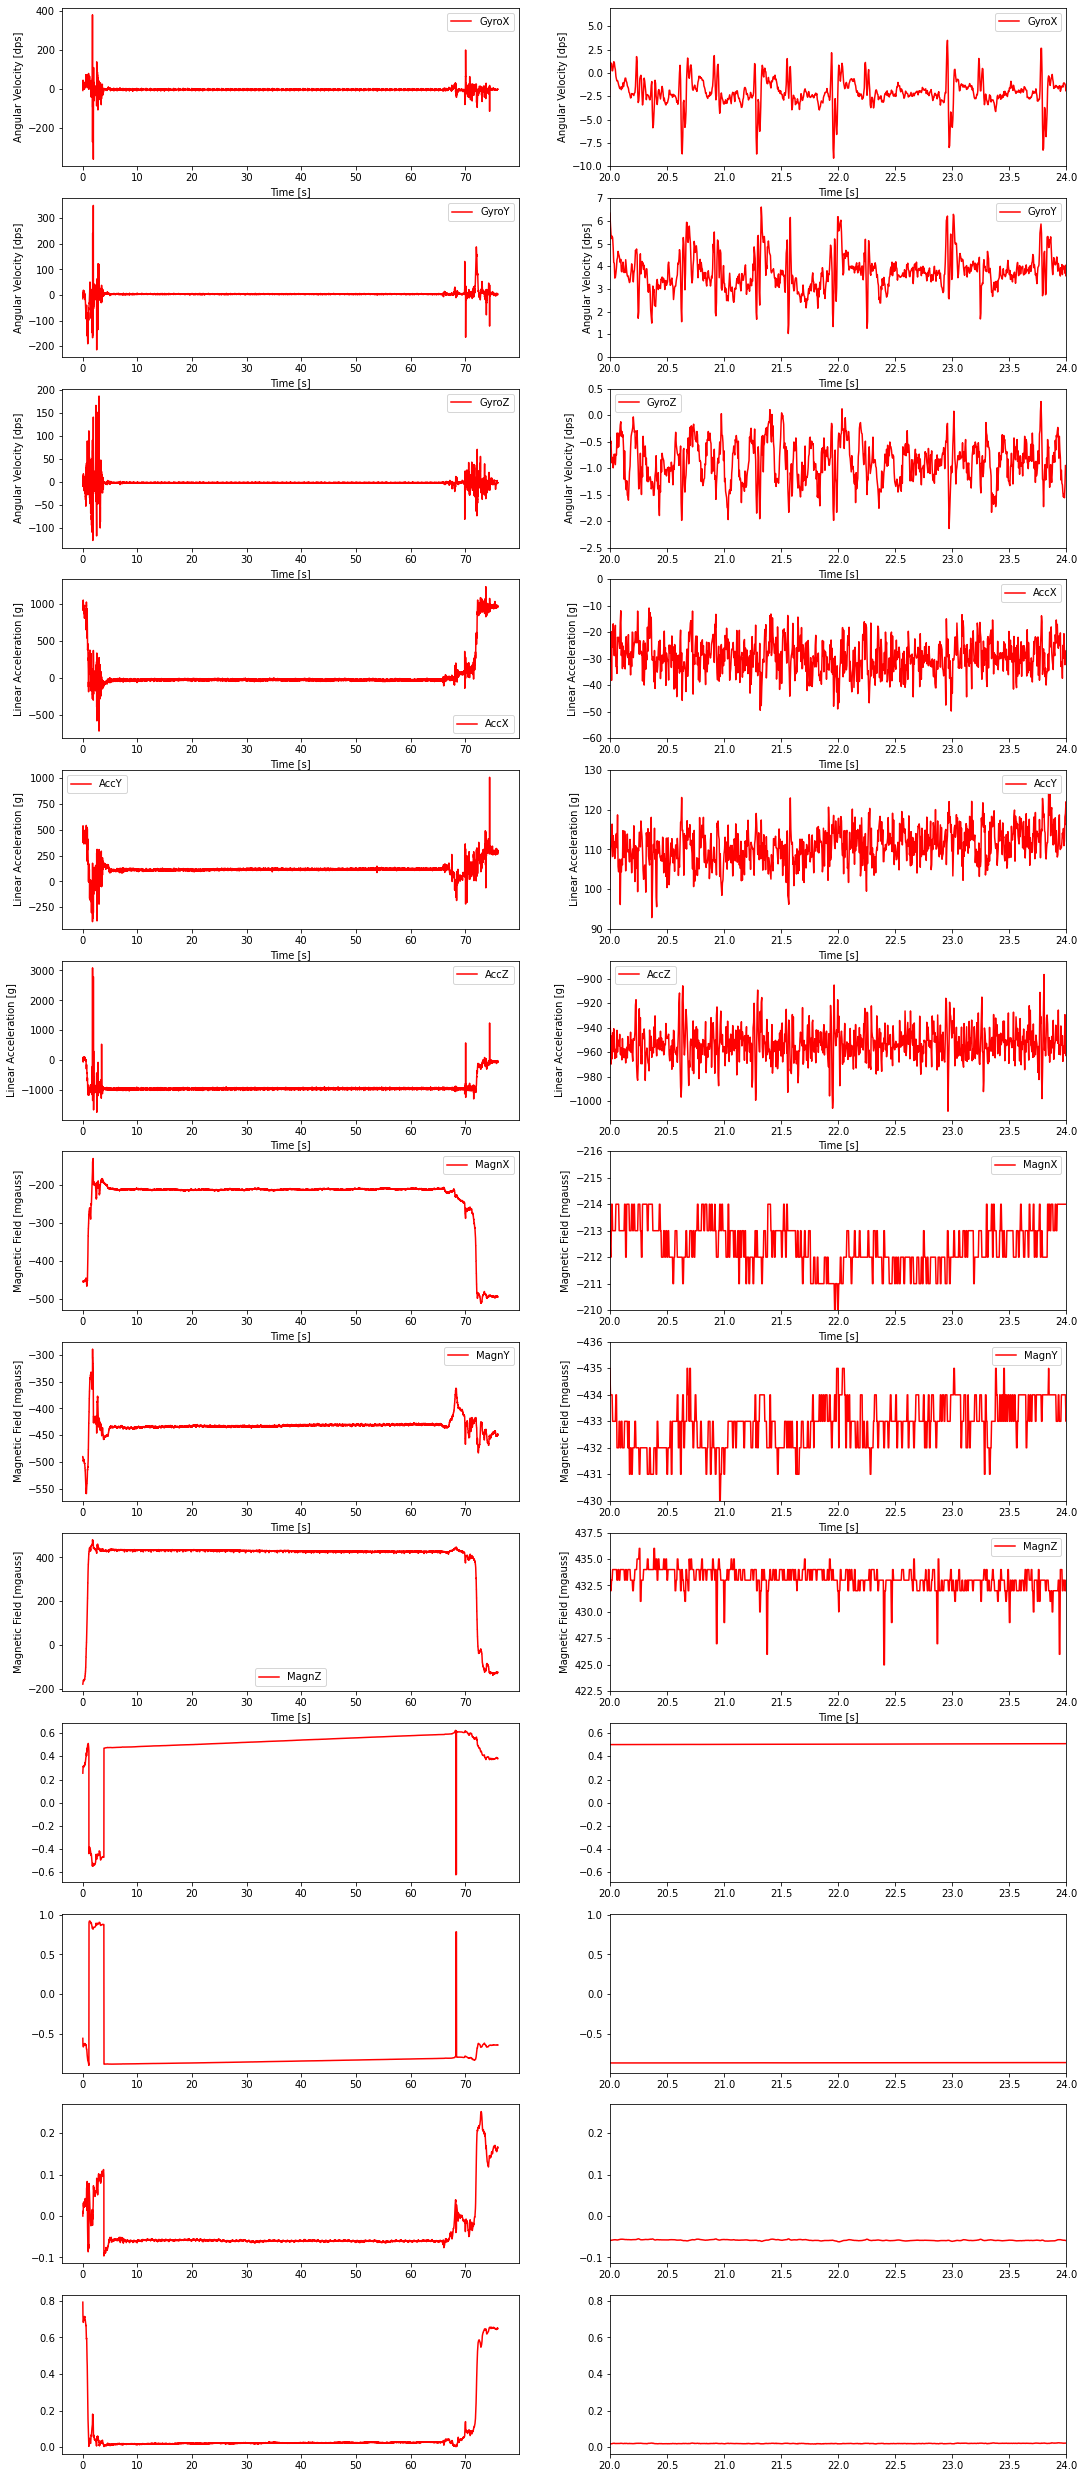

In [21]:
fig, axs = plt.subplots(nrows=Nvar, ncols=2, figsize=(18,45))   #create a figure in which plotting the data

for i in range(2):
    for j in range(Nvar):
        axs[j][i].plot(data["Abs Time"], data[labels[j]], label=labels[j], c='r')
        if i == 1:
            axs[j][i].set_xlim([20,24])
        
axs[0][1].set_ylim([-10,7])
axs[1][1].set_ylim([0,7])
axs[2][1].set_ylim([-2.5,0.5])
axs[3][1].set_ylim([-60,-0])
axs[4][1].set_ylim([90,130])
axs[5][1].set_ylim([-1015,-885])
axs[6][1].set_ylim([-210,-216])
axs[7][1].set_ylim([-430,-436])
axs[8][1].set_ylim([422.5,437.5])

for i in range(2):
    for j in range(9):
        axs[j][i].set_xlabel("Time [s]")
        if j<3:
            axs[j][i].set_ylabel('Angular Velocity [dps]')
        elif j>5:
            axs[j][i].set_ylabel('Magnetic Field [mgauss]')
        else:
            axs[j][i].set_ylabel('Linear Acceleration [g]')
        axs[j][i].legend(loc="best")

Firstly, we see that from 10 seconds to 60 seconds all the measures have a constant behaviour, so we consider this to be the time window we're going to use in the rest of the project. Now we want to calculate some quantities to analyze these columns of data, mean, variance and correlations.

In [22]:
t1_cut = 10
t2_cut = 65

#We select the time window over which performing the analysis

data = data.drop(data.index[range(t2_cut*freq,len(data))])
data = data.drop(data.index[range(t1_cut*freq)])
data

,Log Freq,Timestamp,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ,qw,qi,qj,qk,Abs Time
2000,200,1576222781,-32.635,112.911,-953.796,1.755725,5.022901,-0.809160,-212,-439,432,0.017735,0.482131,-0.873623,-0.063387,9.178571
2001,200,1576222781,-19.154,112.362,-971.608,1.557252,4.198473,-1.083969,-212,-439,432,0.018497,0.482131,-0.873684,-0.062319,9.183036
2002,200,1576222781,-27.450,110.593,-944.280,0.931298,4.320611,-1.099237,-211,-436,428,0.018284,0.482131,-0.873714,-0.061953,9.187500
2003,200,1576222781,-21.777,113.948,-940.803,0.946565,4.137404,-1.267176,-211,-436,428,0.019267,0.482131,-0.873745,-0.061220,9.191964
2004,200,1576222781,-32.391,118.218,-924.394,1.022901,4.702290,-0.992366,-212,-438,433,0.020017,0.482101,-0.873745,-0.061220,9.196429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12995,200,1576222831,-31.842,118.279,-941.901,-1.679389,3.664122,-0.503817,-210,-430,426,0.026676,0.577990,-0.813440,-0.059420,59.700893
12996,200,1576222831,-40.626,116.998,-949.404,-1.129771,4.015267,-0.519084,-210,-430,426,0.026812,0.577990,-0.813440,-0.059359,59.705357
12997,200,1576222831,-33.062,116.693,-949.404,-1.114504,3.587786,-0.717557,-210,-429,428,0.026264,0.577990,-0.813440,-0.059603,59.709821
12998,200,1576222831,-25.254,118.523,-961.787,-1.557252,3.938931,-0.641221,-210,-429,428,0.026125,0.577990,-0.813440,-0.059664,59.714286


Now we print for all the columns remained the mean, standard deviation, minimum, maximum and the 25,50,75 percentiles in the time window we have selected

In [23]:
#get statistical descriptors 
data_stat = data.describe()
data_stat

,Log Freq,Timestamp,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ,qw,qi,qj,qk,Abs Time
count,11000.0,1.100000e+04,11000.000000,11000.000000,11000.000000,11000.000000,11000.000000,11000.000000,11000.000000,11000.000000,11000.000000,11000.000000,11000.000000,11000.000000,11000.000000,11000.000000
mean,200.0,1.576223e+09,-30.560845,115.322613,-949.554925,-2.077170,3.688219,-0.868322,-211.681273,-432.441636,429.996455,0.023589,0.530042,-0.844881,-0.059783,34.458612
std,0.0,1.459514e+01,7.019645,5.339442,14.394306,1.425450,0.717922,0.364963,1.325838,1.728781,2.893303,0.002738,0.027917,0.017669,0.001555,14.591928
min,200.0,1.576223e+09,-66.917000,85.827000,-1015.528000,-10.000000,0.503817,-2.503817,-216.000000,-439.000000,418.000000,0.014462,0.482009,-0.873958,-0.065188,9.178571
25%,200.0,1.576223e+09,-35.197000,111.752000,-958.066000,-2.687023,3.282443,-1.114504,-213.000000,-434.000000,428.000000,0.021638,0.505135,-0.860782,-0.060854,21.829241
50%,200.0,1.576223e+09,-30.439000,115.473000,-950.014000,-2.152672,3.633588,-0.854962,-212.000000,-432.000000,430.000000,0.023858,0.530213,-0.845363,-0.059847,34.445238
75%,200.0,1.576223e+09,-25.864000,118.828000,-941.840000,-1.465649,4.000000,-0.625954,-211.000000,-431.000000,433.000000,0.025727,0.554369,-0.829737,-0.058748,47.072619
max,200.0,1.576223e+09,-5.429000,147.376000,-879.742000,4.473282,7.557252,0.641221,-207.000000,-428.000000,436.000000,0.029752,0.578112,-0.813105,-0.054567,59.718750


In [24]:
#set mean to zero to normalize the data
for l in labels:
    data[l]= (data[l]-data_stat.at["mean",l])/data_stat.at['std',l]

In [25]:
data.describe()

,Log Freq,Timestamp,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ,qw,qi,qj,qk,Abs Time
count,11000.0,1.100000e+04,1.100000e+04,1.100000e+04,1.100000e+04,1.100000e+04,1.100000e+04,1.100000e+04,1.100000e+04,1.100000e+04,1.100000e+04,1.100000e+04,1.100000e+04,1.100000e+04,1.100000e+04,11000.000000
mean,200.0,1.576223e+09,4.904279e-15,-3.304637e-14,-4.482471e-14,2.260328e-15,-7.614439e-15,1.313394e-16,-5.966944e-16,6.632715e-15,3.327564e-14,4.049161e-14,8.031430e-14,5.807325e-13,-1.482491e-13,34.458612
std,0.0,1.459514e+01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,14.591928
min,200.0,1.576223e+09,-5.179202e+00,-5.524101e+00,-4.583276e+00,-5.558126e+00,-4.435580e+00,-4.481262e+00,-3.257358e+00,-3.793635e+00,-4.146283e+00,-3.333362e+00,-1.720549e+00,-1.645693e+00,-3.475854e+00,9.178571
25%,200.0,1.576223e+09,-6.604544e-01,-6.687240e-01,-5.912807e-01,-4.278319e-01,-5.652092e-01,-6.745395e-01,-9.946371e-01,-9.014234e-01,-6.900261e-01,-7.126473e-01,-8.921802e-01,-8.999543e-01,-6.887051e-01,21.829241
50%,200.0,1.576223e+09,1.735768e-02,2.816534e-02,-3.189281e-02,-5.296711e-02,-7.609642e-02,3.660703e-02,-2.403969e-01,2.554611e-01,1.225400e-03,9.814398e-02,6.151898e-03,-2.725477e-02,-4.098810e-02,34.445238
75%,200.0,1.576223e+09,6.691001e-01,6.565082e-01,5.359706e-01,4.290021e-01,4.342819e-01,6.640887e-01,5.138433e-01,8.339034e-01,1.038103e+00,7.808257e-01,8.714170e-01,8.571023e-01,6.656152e-01,47.072619
max,200.0,1.576223e+09,3.580216e+00,6.003135e+00,4.850038e+00,4.595358e+00,5.389207e+00,4.136154e+00,3.530804e+00,2.569230e+00,2.074980e+00,2.250872e+00,1.721924e+00,1.798464e+00,3.354621e+00,59.718750


We normalize the data by subtracting the mean and by dividing for the standard deviation. For the accelerations and the angular velocities the 25 and 75 percentiles are nearly simmetric, so the variables change quite regularly. We notice a higher deviation for the acceleration over X, and the angular velocity along Z 

Now, before performing a fourier analysis of the columns considered we would like to understand if there is some correlation between some of the variables

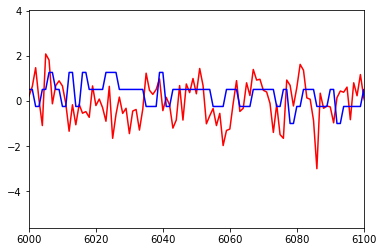

In [26]:
plt.plot(data['AccX'],  c='r')
plt.plot(data['MagnX'], c='b')
plt.xlim([6000,6100])
plt.show()

Now we're going to perform a fourier analysis using the scipy fftpack library; in this way we would like to estrapolate the principal frequencies of the data and see if we can see a frequence near the respiratory rate (and also the hearth rate frequency)

In [27]:
#perform Fourier analysis

sig_fft = 1j*np.zeros((Nvar, len(data)))

for i in range(Nvar):
    sig_fft[i] = fftpack.fft(data[labels[i]].values)

power = np.abs(sig_fft)
sample_freq = fftpack.fftfreq(len(data), d=dt)

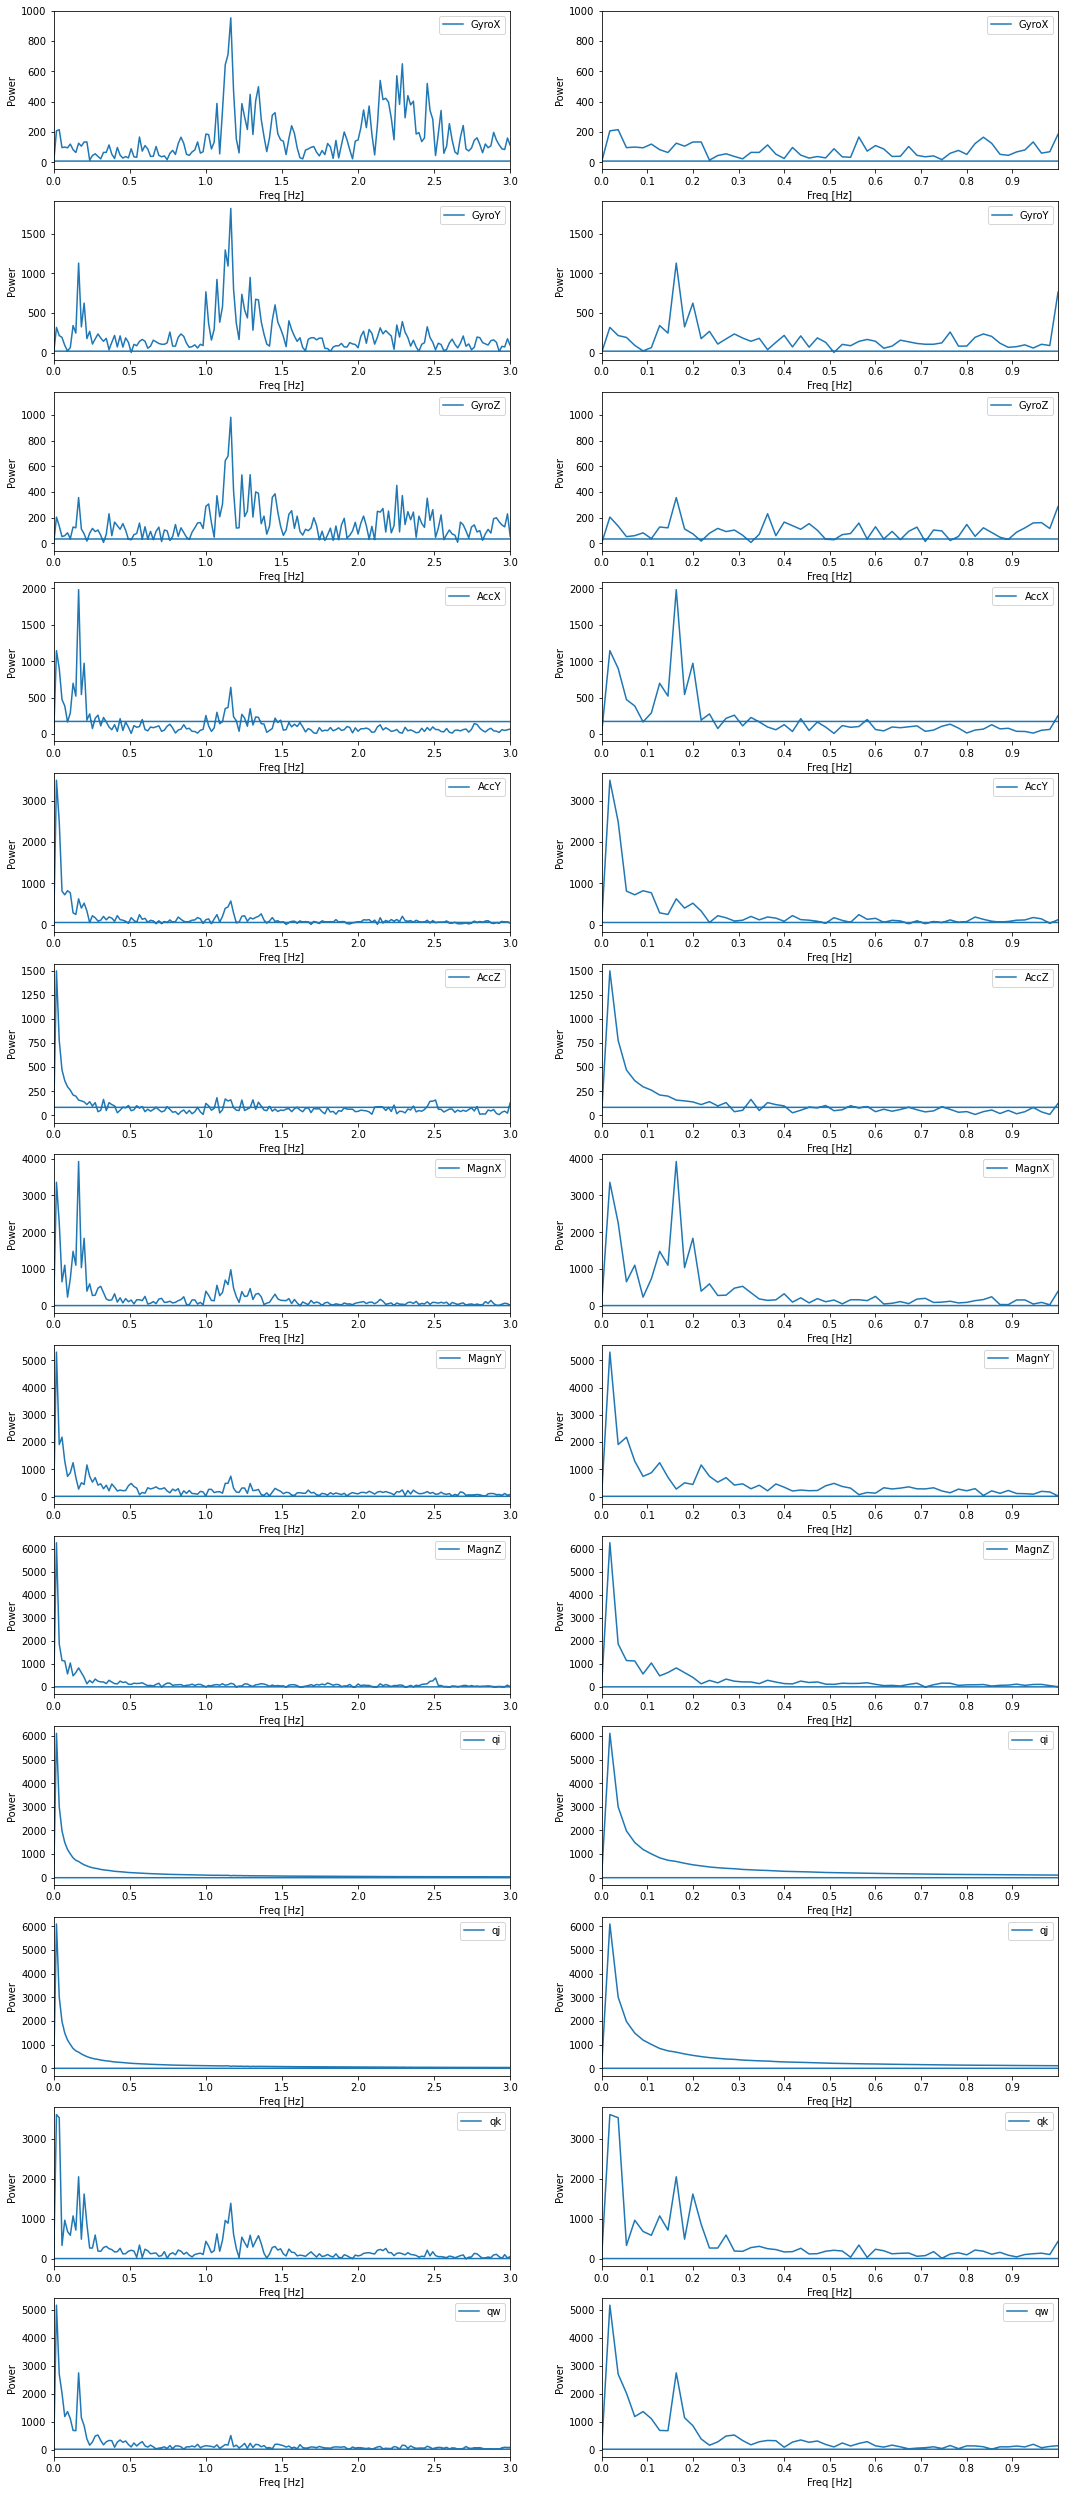

In [28]:
fig, axs = plt.subplots(nrows=Nvar, ncols=2, figsize=(18,45))

for i in range(2):
    for j in range(Nvar):
        axs[j][i].plot(sample_freq, power[j], label=labels[j])
        if i == 0:
            axs[j][0].set_xlim([0,3])
        else:
            axs[j][i].set_xlim([0,1])
            axs[j][i].set_xticks(np.arange(0,1,0.1))
        

for ax in axs.flatten():
    ax.set_xlabel("Freq [Hz]")
    ax.set_ylabel("Power")
    ax.legend(loc="best")

In [29]:
#filter signal with Butterworth bandpass filter in [0.1,0.9] Hz range

filtered = np.zeros((Nvar,len(data)))
sos = signal.butter(2, [0.1,0.4], 'bandpass', fs=freq, output='sos')
for i in range(Nvar):
    filtered[i] = signal.sosfilt(sos, data[labels[i]])

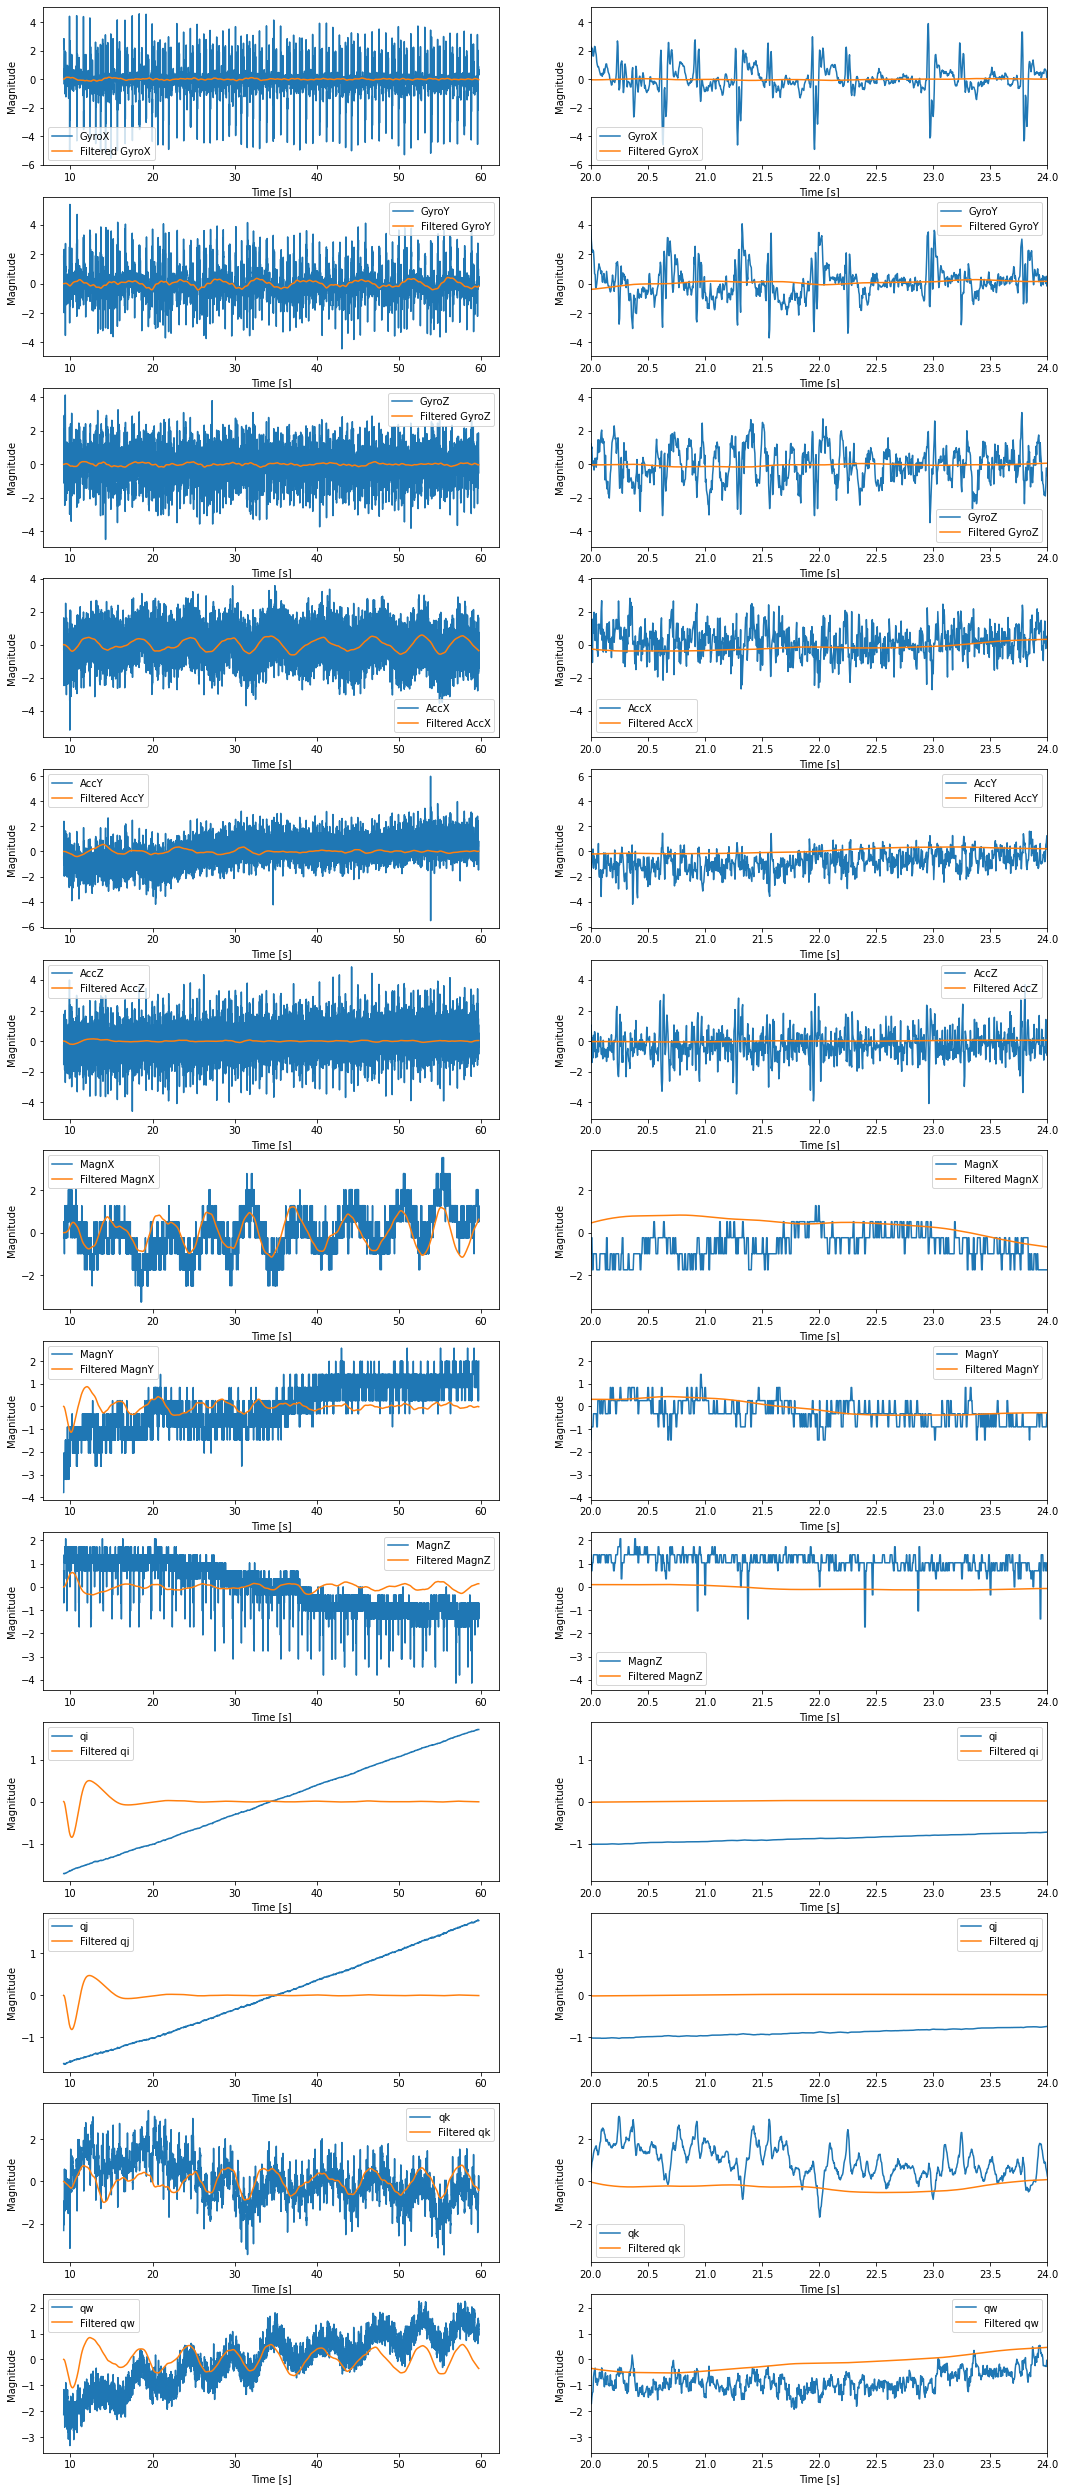

In [30]:
#plot filtered Gyro and Acc
fig, axs = plt.subplots(nrows=Nvar, ncols=2, figsize=(18,45))

for i in range(2):
    for j in range(Nvar):
        axs[j][i].plot(data["Abs Time"], data[labels[j]], label=labels[j])
        axs[j][i].plot(data["Abs Time"], filtered[j],     label=("Filtered "+labels[j]))
        if i == 1:
            axs[j][i].set_xlim([20,24])

for ax in axs.flatten():
    ax.set_xlabel("Time [s]")
    ax.set_ylabel("Magnitude")
    ax.legend(loc="best")

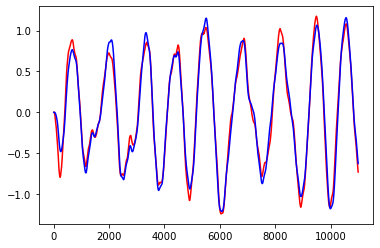

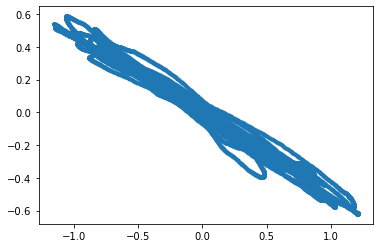

correlation between accX and magnX 
 [[ 1.         -0.98929172]
 [-0.98929172  1.        ]]

 correlation between accX and GyroY 
 [[ 1.         -0.00880155]
 [-0.00880155  1.        ]]

 correlation between accX and GyroZ 
 [[1.         0.41414203]
 [0.41414203 1.        ]]

 correlation between magnX and GyroY 
 [[1.         0.04866411]
 [0.04866411 1.        ]]

 correlation between magnX and GyroZ
 [[ 1.         -0.42541851]
 [-0.42541851  1.        ]]

 correlation between GyroZ and GyroY
 [[ 1.         -0.32878881]
 [-0.32878881  1.        ]]
correlation between accX and qi 
 [[1.         0.22092116]
 [0.22092116 1.        ]]

 correlation between accX and qj 
 [[1.         0.21514408]
 [0.21514408 1.        ]]

 correlation between accX and qk 
 [[1.         0.88873132]
 [0.88873132 1.        ]]
correlation between accX and qw 
 [[1.         0.91309951]
 [0.91309951 1.        ]]


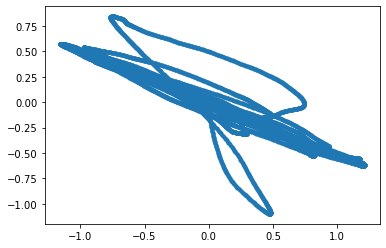

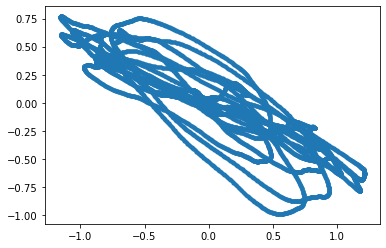

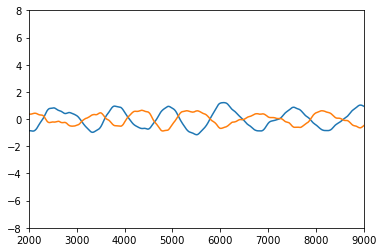

correlation between gyroY and qi 
 [[ 1.         -0.08231438]
 [-0.08231438  1.        ]]

 correlation between gyroY and qj 
 [[ 1.         -0.08465274]
 [-0.08465274  1.        ]]

 correlation between gyroY and qk 
 [[1.         0.08954751]
 [0.08954751 1.        ]]
correlation between gyroY and qw 
 [[ 1.         -0.08397712]
 [-0.08397712  1.        ]]
correlation between gyroZ and qi 
 [[1.         0.24848471]
 [0.24848471 1.        ]]

 correlation between gyroZ and qj 
 [[1.         0.24725776]
 [0.24725776 1.        ]]

 correlation between gyroZ and qk 
 [[1.         0.25080962]
 [0.25080962 1.        ]]
correlation between gyroZ and qw 
 [[1.         0.49209045]
 [0.49209045 1.        ]]
correlation between magnX and qi 
 [[ 1.       -0.153609]
 [-0.153609  1.      ]]

 correlation between magnX and qj 
 [[ 1.         -0.14819055]
 [-0.14819055  1.        ]]

 correlation between magnX and qk 
 [[ 1.         -0.88184613]
 [-0.88184613  1.        ]]
correlation between magnX 

In [40]:
plt.plot(2*filtered[3], c='r')
#plt.plot(filtered[1], c='green')
#plt.plot(filtered[2], c='black')
plt.plot(-filtered[6], c='b')
plt.show()
plt.plot(filtered[6], filtered[3], '.')
plt.show()
print('correlation between accX and magnX \n',np.corrcoef(filtered[3], y=filtered[6]))
print('\n correlation between accX and GyroY \n',np.corrcoef(filtered[3], y=filtered[1]))
print('\n correlation between accX and GyroZ \n',np.corrcoef(filtered[3], y=filtered[2]))
print('\n correlation between magnX and GyroY \n',np.corrcoef(filtered[6], y=filtered[1]))
print('\n correlation between magnX and GyroZ\n',np.corrcoef(filtered[6], y=filtered[2]))
print('\n correlation between GyroZ and GyroY\n',np.corrcoef(filtered[2], y=filtered[1]))
print('correlation between accX and qi \n',np.corrcoef(filtered[3], y=filtered[9]))
print('\n correlation between accX and qj \n',np.corrcoef(filtered[3], y=filtered[10]))
print('\n correlation between accX and qk \n',np.corrcoef(filtered[3], y=filtered[11]))
print('correlation between accX and qw \n',np.corrcoef(filtered[3], y=filtered[12]))

plt.plot(filtered[6], filtered[12], '.')
plt.show()
plt.plot(filtered[6], filtered[11], '.')
plt.show()
plt.plot(filtered[6])
plt.plot(filtered[11])
plt.xlim([2000,9000])
plt.ylim([-8,8])
plt.show()

print('correlation between gyroY and qi \n',np.corrcoef(filtered[1], y=filtered[9]))
print('\n correlation between gyroY and qj \n',np.corrcoef(filtered[1], y=filtered[10]))
print('\n correlation between gyroY and qk \n',np.corrcoef(filtered[1], y=filtered[11]))
print('correlation between gyroY and qw \n',np.corrcoef(filtered[1], y=filtered[12]))
print('correlation between gyroZ and qi \n',np.corrcoef(filtered[2], y=filtered[9]))
print('\n correlation between gyroZ and qj \n',np.corrcoef(filtered[2], y=filtered[10]))
print('\n correlation between gyroZ and qk \n',np.corrcoef(filtered[2], y=filtered[11]))
print('correlation between gyroZ and qw \n',np.corrcoef(filtered[2], y=filtered[12]))
print('correlation between magnX and qi \n',np.corrcoef(filtered[6], y=filtered[9]))
print('\n correlation between magnX and qj \n',np.corrcoef(filtered[6], y=filtered[10]))
print('\n correlation between magnX and qk \n',np.corrcoef(filtered[6], y=filtered[11]))
print('correlation between magnX and qw \n',np.corrcoef(filtered[6], y=filtered[12]))


We find a great correlation between magnX and accX

The filtered signal has a regular behaviour (oscillating) for the acceleration only in the X direction (we think about it as the direction that goes through the body), for the angular velocity along Y and for the magnetic field we find a regular oscillation in the X direction

In [131]:
#plot filtered spectrum
sig_fft_new = 1j*np.zeros((Nvar, len(data)))

for i in range(Nvar):
    sig_fft_new[i] = fftpack.fft(filtered[i])

power_new = np.abs(sig_fft_new)

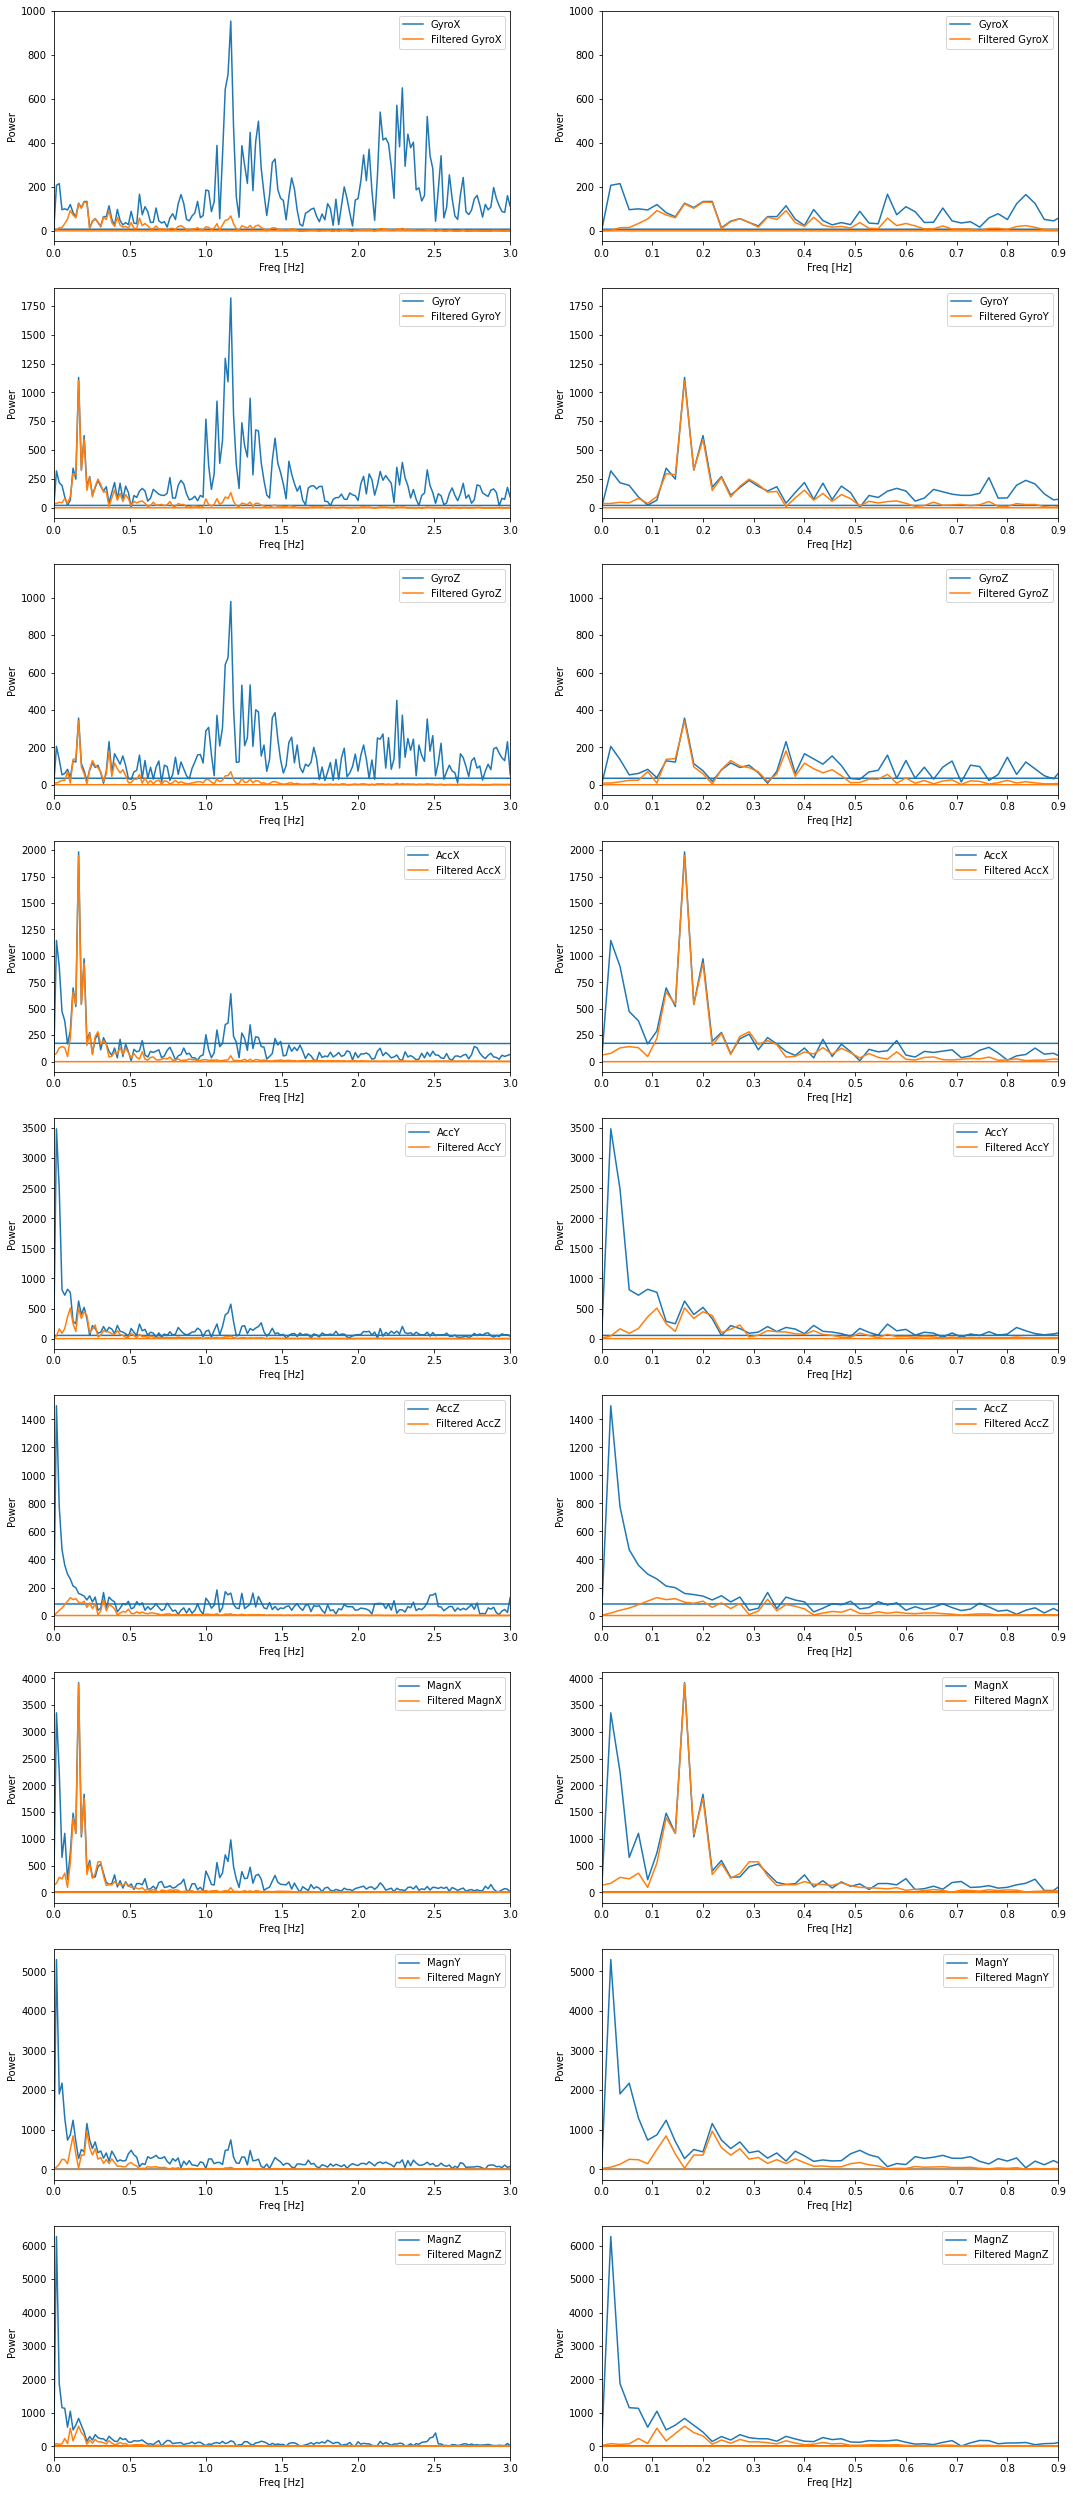

In [132]:
fig, axs = plt.subplots(nrows=Nvar, ncols=2, figsize=(18,45))

for i in range(2):
    for j in range(Nvar):
        axs[j][i].plot(sample_freq, power[j],     label=labels[j])
        axs[j][i].plot(sample_freq, power_new[j], label=("Filtered "+labels[j]))
        if i == 0:
            axs[j][0].set_xlim([0,3])
        else:
            axs[j][i].set_xlim([0,0.8])
            axs[j][i].set_xticks(np.arange(0,1,0.1))
        

for ax in axs.flatten():
    ax.set_xlabel("Freq [Hz]")
    ax.set_ylabel("Power")
    ax.legend(loc="best")

We see well the hearth frequence, near 1.2 Hz in almost all the plots. For the respiration rate we see some possible result (the rate is about 12 RPM, so a frequency near 0.2 Hz) in the angular velocities in Y (in particular) and Z. In the acceleration along X is quite evident a peak between 0.1 and 0.2 Hz. Also in the magnetic field along X we see a high peak in that frequency. We can try to estimate the rate by picking the power maximum of the frequencies in a certain window (let's say {0.1,0.3}). 